In [2]:
import cv2
import kornia as K
import kornia.feature as KF
import matplotlib.pyplot as plt
import numpy as np
import torch
from kornia.feature.adalam import AdalamFilter
from kornia_moons.viz import *

device = K.utils.get_cuda_or_mps_device_if_available()
print(device)

cuda:0


In [7]:
# Function to load, scale, and save an image
def scale_and_save_image(input_path, output_path, scale_factor=0.25):
    # Load the image
    image = cv2.imread(input_path)
    if image is None:
        print(f"Failed to load image: {input_path}")
        return

    # Calculate the new dimensions
    new_width = int(image.shape[1] * scale_factor)
    new_height = int(image.shape[0] * scale_factor)
    new_dim = (new_width, new_height)

    # Resize the image
    scaled_image = cv2.resize(image, new_dim, interpolation=cv2.INTER_AREA)

    # Save the scaled image
    cv2.imwrite(output_path, scaled_image)
    print(f"Image saved to: {output_path}")

In [9]:
fname1 = "./scaled/img1.jpg"
fname2 = "./scaled/img2.jpg"

In [10]:
scale_and_save_image("./selected_JPG/IMG_4602.JPG", fname1)
scale_and_save_image("./selected_JPG/IMG_4605.JPG", fname2)

Image saved to: ./scaled/img1.jpg
Image saved to: ./scaled/img2.jpg


In [11]:
lg_matcher = KF.LightGlueMatcher("disk").eval().to(device)


img1 = K.io.load_image(fname1, K.io.ImageLoadType.RGB32, device=device)[None, ...]
img2 = K.io.load_image(fname2, K.io.ImageLoadType.RGB32, device=device)[None, ...]

num_features = 2048
disk = KF.DISK.from_pretrained("depth").to(device)

hw1 = torch.tensor(img1.shape[2:], device=device)
hw2 = torch.tensor(img2.shape[2:], device=device)


with torch.inference_mode():
    inp = torch.cat([img1, img2], dim=0)
    features1, features2 = disk(inp, num_features, pad_if_not_divisible=True)
    kps1, descs1 = features1.keypoints, features1.descriptors
    kps2, descs2 = features2.keypoints, features2.descriptors
    lafs1 = KF.laf_from_center_scale_ori(kps1[None], torch.ones(1, len(kps1), 1, 1, device=device))
    lafs2 = KF.laf_from_center_scale_ori(kps2[None], torch.ones(1, len(kps2), 1, 1, device=device))
    dists, idxs = lg_matcher(descs1, descs2, lafs1, lafs2, hw1=hw1, hw2=hw2)


print(f"{idxs.shape[0]} tentative matches with DISK LightGlue")

Loaded LightGlue model


/home/murat/anaconda3/envs/mf3D/lib/python3.8/site-packages/kornia/feature/integrated.py:464: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hw1_ = torch.tensor(hw1, device=dev)
/home/murat/anaconda3/envs/mf3D/lib/python3.8/site-packages/kornia/feature/integrated.py:468: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hw2_ = torch.tensor(hw2, device=dev)


122 tentative matches with DISK LightGlue


In [13]:
def get_matching_keypoints(kp1, kp2, idxs):
    mkpts1 = kp1[idxs[:, 0]]
    mkpts2 = kp2[idxs[:, 1]]
    return mkpts1, mkpts2

mkpts1, mkpts2 = get_matching_keypoints(kps1, kps2, idxs)

Fm, inliers = cv2.findFundamentalMat(
    mkpts1.detach().cpu().numpy(), mkpts2.detach().cpu().numpy(), cv2.USAC_MAGSAC, 1.0, 0.999, 100000
)
inliers = inliers > 0
print(f"{inliers.sum()} inliers with DISK")

20 inliers with DISK


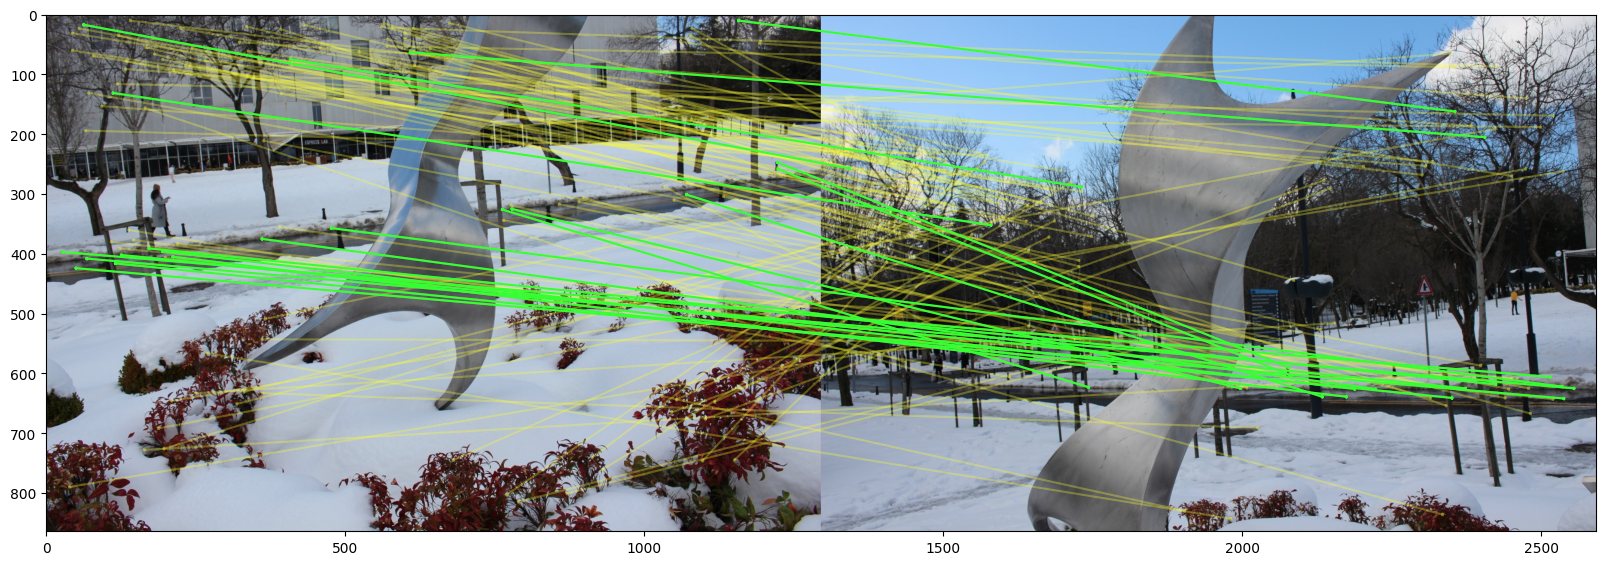

In [14]:
draw_LAF_matches(
    KF.laf_from_center_scale_ori(kps1[None].cpu()),
    KF.laf_from_center_scale_ori(kps2[None].cpu()),
    idxs.cpu(),
    K.tensor_to_image(img1.cpu()),
    K.tensor_to_image(img2.cpu()),
    inliers,
    draw_dict={"inlier_color": (0.2, 1, 0.2), "tentative_color": (1, 1, 0.2, 0.3), "feature_color": None, "vertical": False},
)